In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K

# --- New Imports for ResNet Architectures ---
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
# --- End of New Imports ---


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.10.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Appendicitis images: 1339
No appendicitis images: 382
Total images: 1721


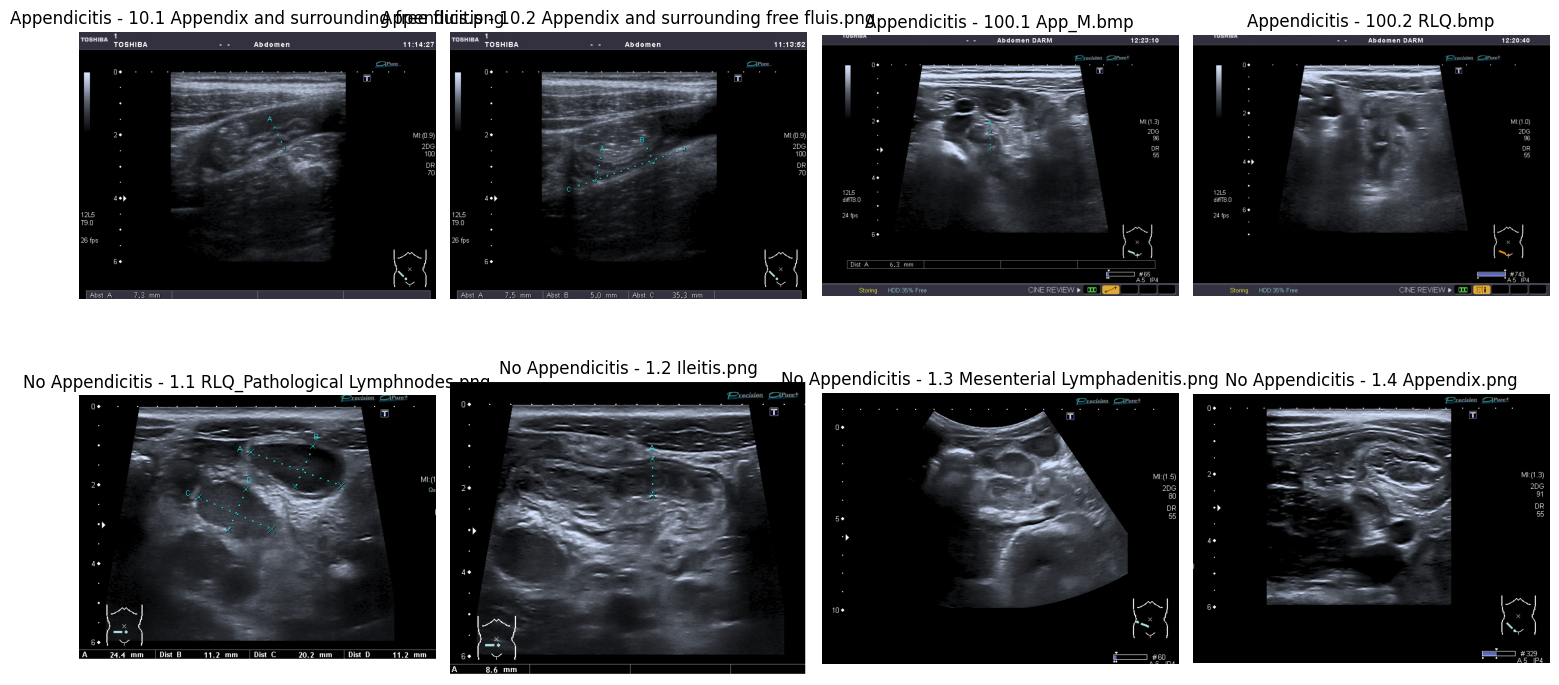

Loading appendicitis images...
Loading no appendicitis images...
Loaded 1721 images with shape: (1721, 224, 224, 3)
Labels distribution: [ 382 1339]


In [3]:
# Define paths
# PLEASE ADJUST THESE PATHS IF YOUR DIRECTORY STRUCTURE IS DIFFERENT
appendicitis_path = "images/appendicitis_images/"
no_appendicitis_path = "images/no_appendicitis_images/"

# Function to load and explore dataset
def explore_dataset():
    # Count images in each category
    appendicitis_count = len([f for f in os.listdir(appendicitis_path) 
                             if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))])
    no_appendicitis_count = len([f for f in os.listdir(no_appendicitis_path) 
                                if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))])
    
    print(f"Appendicitis images: {appendicitis_count}")
    print(f"No appendicitis images: {no_appendicitis_count}")
    print(f"Total images: {appendicitis_count + no_appendicitis_count}")
    
    return appendicitis_count, no_appendicitis_count

appendicitis_count, no_appendicitis_count = explore_dataset()

def plot_sample_images(num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    # Plot appendicitis samples
    appendicitis_files = [f for f in os.listdir(appendicitis_path) 
                         if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    for i in range(min(num_samples, len(appendicitis_files))):
        img_path = os.path.join(appendicitis_path, appendicitis_files[i])
        img = Image.open(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Appendicitis - {appendicitis_files[i]}')
        axes[0, i].axis('off')
    
    # Plot no appendicitis samples
    no_appendicitis_files = [f for f in os.listdir(no_appendicitis_path) 
                            if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    for i in range(min(num_samples, len(no_appendicitis_files))):
        img_path = os.path.join(no_appendicitis_path, no_appendicitis_files[i])
        img = Image.open(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'No Appendicitis - {no_appendicitis_files[i]}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images()

def load_and_preprocess_data(img_size=(224, 224)):
    """
    Load and preprocess images from both categories
    """
    images = []
    labels = []
    
    # Load appendicitis images (label = 1)
    print("Loading appendicitis images...")
    appendicitis_files = [f for f in os.listdir(appendicitis_path) 
                         if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    
    for filename in appendicitis_files:
        try:
            img_path = os.path.join(appendicitis_path, filename)
            img = Image.open(img_path)
            
            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Resize image
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalize to [0,1]
            
            images.append(img_array)
            labels.append(1)  # Appendicitis
            
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    
    # Load no appendicitis images (label = 0)
    print("Loading no appendicitis images...")
    no_appendicitis_files = [f for f in os.listdir(no_appendicitis_path) 
                            if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    
    for filename in no_appendicitis_files:
        try:
            img_path = os.path.join(no_appendicitis_path, filename)
            img = Image.open(img_path)
            
            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Resize image
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalize to [0,1]
            
            images.append(img_array)
            labels.append(0)  # No appendicitis
            
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    
    return np.array(images), np.array(labels)

# Load the data
X, y = load_and_preprocess_data()
print(f"Loaded {len(X)} images with shape: {X.shape}")
print(f"Labels distribution: {np.bincount(y)}")

In [4]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Check class distribution
print("\nClass distribution:")
print(f"Train - Appendicitis: {np.sum(y_train)}, No appendicitis: {len(y_train) - np.sum(y_train)}")
print(f"Val - Appendicitis: {np.sum(y_val)}, No appendicitis: {len(y_val) - np.sum(y_val)}")
print(f"Test - Appendicitis: {np.sum(y_test)}, No appendicitis: {len(y_test) - np.sum(y_test)}")

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator()

# Calculate class weights to handle imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("\nClass weights:", class_weight_dict)
print(f"Weight for no appendicitis (class 0): {class_weight_dict[0]:.2f}")
print(f"Weight for appendicitis (class 1): {class_weight_dict[1]:.2f}")

Training set: 1204 images
Validation set: 258 images
Test set: 259 images

Class distribution:
Train - Appendicitis: 937, No appendicitis: 267
Val - Appendicitis: 201, No appendicitis: 57
Test - Appendicitis: 201, No appendicitis: 58

Class weights: {0: 2.254681647940075, 1: 0.6424759871931697}
Weight for no appendicitis (class 0): 2.25
Weight for appendicitis (class 1): 0.64


In [5]:
def build_backbone_model(arch_name, input_shape=(224, 224, 3), base_trainable=False):
    """
    Returns the base model and its specific preprocessing function.
    arch_name: one of 'vgg16', 'resnet50', 'resnet101', 'resnet152'
    """
    arch_name = arch_name.lower()
    
    # A dictionary to hold our model classes and their preprocessing functions
    models = {
        "vgg16": (VGG16, None),  # VGG16 will use the [0,1] scaled data directly
        "resnet50": (ResNet50, resnet_preprocess_input),
        "resnet101": (ResNet101, resnet_preprocess_input),
        "resnet152": (ResNet152, resnet_preprocess_input)
    }
    
    if arch_name not in models:
        raise ValueError(f"Unknown architecture: {arch_name}. Please choose from {list(models.keys())}")

    ModelClass, preprocess_fn = models[arch_name]
    
    base = ModelClass(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = base_trainable
    
    return base, preprocess_fn


def build_full_model(arch_name, input_shape=(224, 224, 3)):
    """
    Builds a complete model with a custom classifier on top of a pretrained backbone.
    """
    base_model, preprocess_fn = build_backbone_model(arch_name, input_shape=input_shape, base_trainable=False)
    
    x_input = keras.Input(shape=input_shape, name="input_image")
    
    # Preprocessing step
    if preprocess_fn:
        # ResNet models expect [0, 255] range. We scale our [0, 1] data back up.
        x = keras.layers.Lambda(lambda t: t * 255.0)(x_input)
        x = preprocess_fn(x)
    else:
        # VGG16 will use the [0, 1] data as is.
        x = x_input

    # Add the backbone
    x = base_model(x, training=False)  # Run backbone in inference mode
    
    # Add the custom classifier head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=x_input, outputs=output)
    
    return model, base_model

# Let's test it by building one model to see the architecture
print("Building a ResNet50 model to test the function...")
test_model, _ = build_full_model('resnet50')
test_model.summary()
print("\nModel built successfully!")

Building a ResNet50 model to test the function...
94765736/94765736 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_aver

In [6]:
def f1_score(y_true, y_pred):
    """Custom F1 score metric from your original notebook."""
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))

def compile_model_phase(model, learning_rate=1e-3, use_f1=True):
    """Compiles the model with a specific learning rate and metrics."""
    metrics_list = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
    if use_f1:
        metrics_list.append(f1_score)
        
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=metrics_list
    )

def get_callbacks(arch_name, phase, monitor_metric='val_accuracy'):
    """Creates a list of callbacks for a given training phase."""
    fname = f'best_{arch_name}_phase{phase}.keras'  # Use the modern .keras format
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=8 if phase == 2 else 10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3 if phase == 2 else 5,
            min_lr=1e-8,
            verbose=1
        ),
        ModelCheckpoint(
            fname,
            monitor=monitor_metric,
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

def unfreeze_for_finetune(base_model, arch_name):
    """Unfreezes the top layers of the backbone for fine-tuning."""
    if 'resnet' in arch_name:
        # For ResNets, a common strategy is to unfreeze the last convolutional block.
        # This number can be tuned, but it's a good starting point.
        layers_to_unfreeze = {
            'resnet50': 22,   # Unfreeze from conv5_block1_out onward
            'resnet101': 22,  # Same block structure
            'resnet152': 55   # Deeper, unfreeze from conv5_block1_out onward
        }.get(arch_name, 22)
        
        for layer in base_model.layers[:-layers_to_unfreeze]:
            layer.trainable = False
        for layer in base_model.layers[-layers_to_unfreeze:]:
            layer.trainable = True
    else: # For VGG16
        for layer in base_model.layers[:-4]: # Unfreeze last conv block
            layer.trainable = False
        for layer in base_model.layers[-4:]:
            layer.trainable = True

def evaluate_and_report(model, X_data, y_data, set_name="Validation"):
    """Predicts, evaluates, and prints a classification report."""
    predictions = model.predict(X_data, verbose=0)
    binary_predictions = (predictions > 0.5).astype(int).ravel()
    
    report = classification_report(y_data, binary_predictions, target_names=['No Appendicitis', 'Appendicitis'], output_dict=False)
    print(f"\n--- {set_name} Classification Report ---")
    print(report)
    
    cm = confusion_matrix(y_data, binary_predictions)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn + K.epsilon())
    specificity = tn / (tn + fp + K.epsilon())
    
    print(f"Sensitivity (Recall): {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print("------------------------------------")
    
    return {
        "confusion_matrix": cm,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "classification_report": report
    }

print("Training utility functions defined successfully.")

Training utility functions defined successfully.


In [7]:
# A list of all model architectures we want to train
architectures = ['vgg16', 'resnet50', 'resnet101', 'resnet152']
all_results = {}

# Ensure labels are float32 for Keras
y_train_float = y_train.astype('float32')
y_val_float   = y_val.astype('float32')
y_test_float  = y_test.astype('float32')

for arch in architectures:
    print(f"\n==============================================")
    print(f"  TRAINING ARCHITECTURE: {arch.upper()}  ")
    print(f"==============================================")
    
    # 1. Build the model
    model, base_model = build_full_model(arch, input_shape=(224, 224, 3))
    
    # --- PHASE 1: TRANSFER LEARNING ---
    print("\n--- Starting Phase 1: Training top layers (backbone frozen) ---")
    
    # Compile with a higher learning rate
    compile_model_phase(model, learning_rate=1e-3, use_f1=True)
    
    # Get callbacks for this phase
    callbacks_phase1 = get_callbacks(arch, phase=1, monitor_metric='val_accuracy')
    
    print(f"Backbone trainable layers: {sum(1 for l in base_model.layers if l.trainable)} / {len(base_model.layers)}")
    
    history_phase1 = model.fit(
        train_datagen.flow(X_train, y_train_float, batch_size=32),
        epochs=20,
        validation_data=(X_val, y_val_float),
        class_weight=class_weight_dict,
        callbacks=callbacks_phase1,
        verbose=1
    )
    
    # --- PHASE 2: FINE-TUNING ---
    print("\n--- Starting Phase 2: Fine-tuning backbone ---")
    
    # Unfreeze the top layers of the base model
    unfreeze_for_finetune(base_model, arch)
    print(f"After unfreezing, trainable layers in backbone: {sum(1 for l in base_model.layers if l.trainable)} / {len(base_model.layers)}")
    
    # Re-compile with a much lower learning rate for fine-tuning
    compile_model_phase(model, learning_rate=1e-5, use_f1=True)
    
    # Get new callbacks for phase 2
    callbacks_phase2 = get_callbacks(arch, phase=2, monitor_metric='val_accuracy')
    
    history_phase2 = model.fit(
        train_datagen.flow(X_train, y_train_float, batch_size=16), # Smaller batch size for fine-tuning
        epochs=15,
        validation_data=(X_val, y_val_float),
        class_weight=class_weight_dict,
        callbacks=callbacks_phase2,
        verbose=1
    )
    
    # --- FINAL EVALUATION ---
    # The best weights from phase 2 are already restored by the EarlyStopping callback
    print(f"\n--- Final Evaluation for {arch.upper()} ---")
    
    # Evaluate on the validation set
    val_eval = evaluate_and_report(model, X_val, y_val, set_name=f"{arch.upper()} Final Validation")
    
    # Evaluate on the unseen test set
    test_eval = evaluate_and_report(model, X_test, y_test, set_name=f"{arch.upper()} Final Test")
    
    # Store all results for this architecture
    all_results[arch] = {
        "history_phase1": history_phase1.history,
        "history_phase2": history_phase2.history,
        "validation_evaluation": val_eval,
        "test_evaluation": test_eval
    }

print("\n\nAll training and evaluation complete!")


  TRAINING ARCHITECTURE: VGG16  

--- Starting Phase 1: Training top layers (backbone frozen) ---
Backbone trainable layers: 0 / 19
Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.7695 - accuracy: 0.5922 - precision: 0.8213 - recall: 0.6083 - f1_score: 0.6867
Epoch 1: val_accuracy improved from -inf to 0.77907, saving model to best_vgg16_phase1.keras
38/38 [==============================] - 8s 76ms/step - loss: 0.7695 - accuracy: 0.5922 - precision: 0.8213 - recall: 0.6083 - f1_score: 0.6867 - val_loss: 0.5704 - val_accuracy: 0.7791 - val_precision: 0.7791 - val_recall: 1.0000 - val_f1_score: 0.8525 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.5847 - precision: 0.8346 - recall: 0.5816 - f1_score: 0.6819
Epoch 2: val_accuracy did not improve from 0.77907
38/38 [==============================] - 6s 164ms/step - loss: 0.6802 - accuracy: 0.5847 - precision: 0.8346 - recall: 0.5816 - f1_score: 0.6819 - val_loss:


--- Training History for VGG16 ---


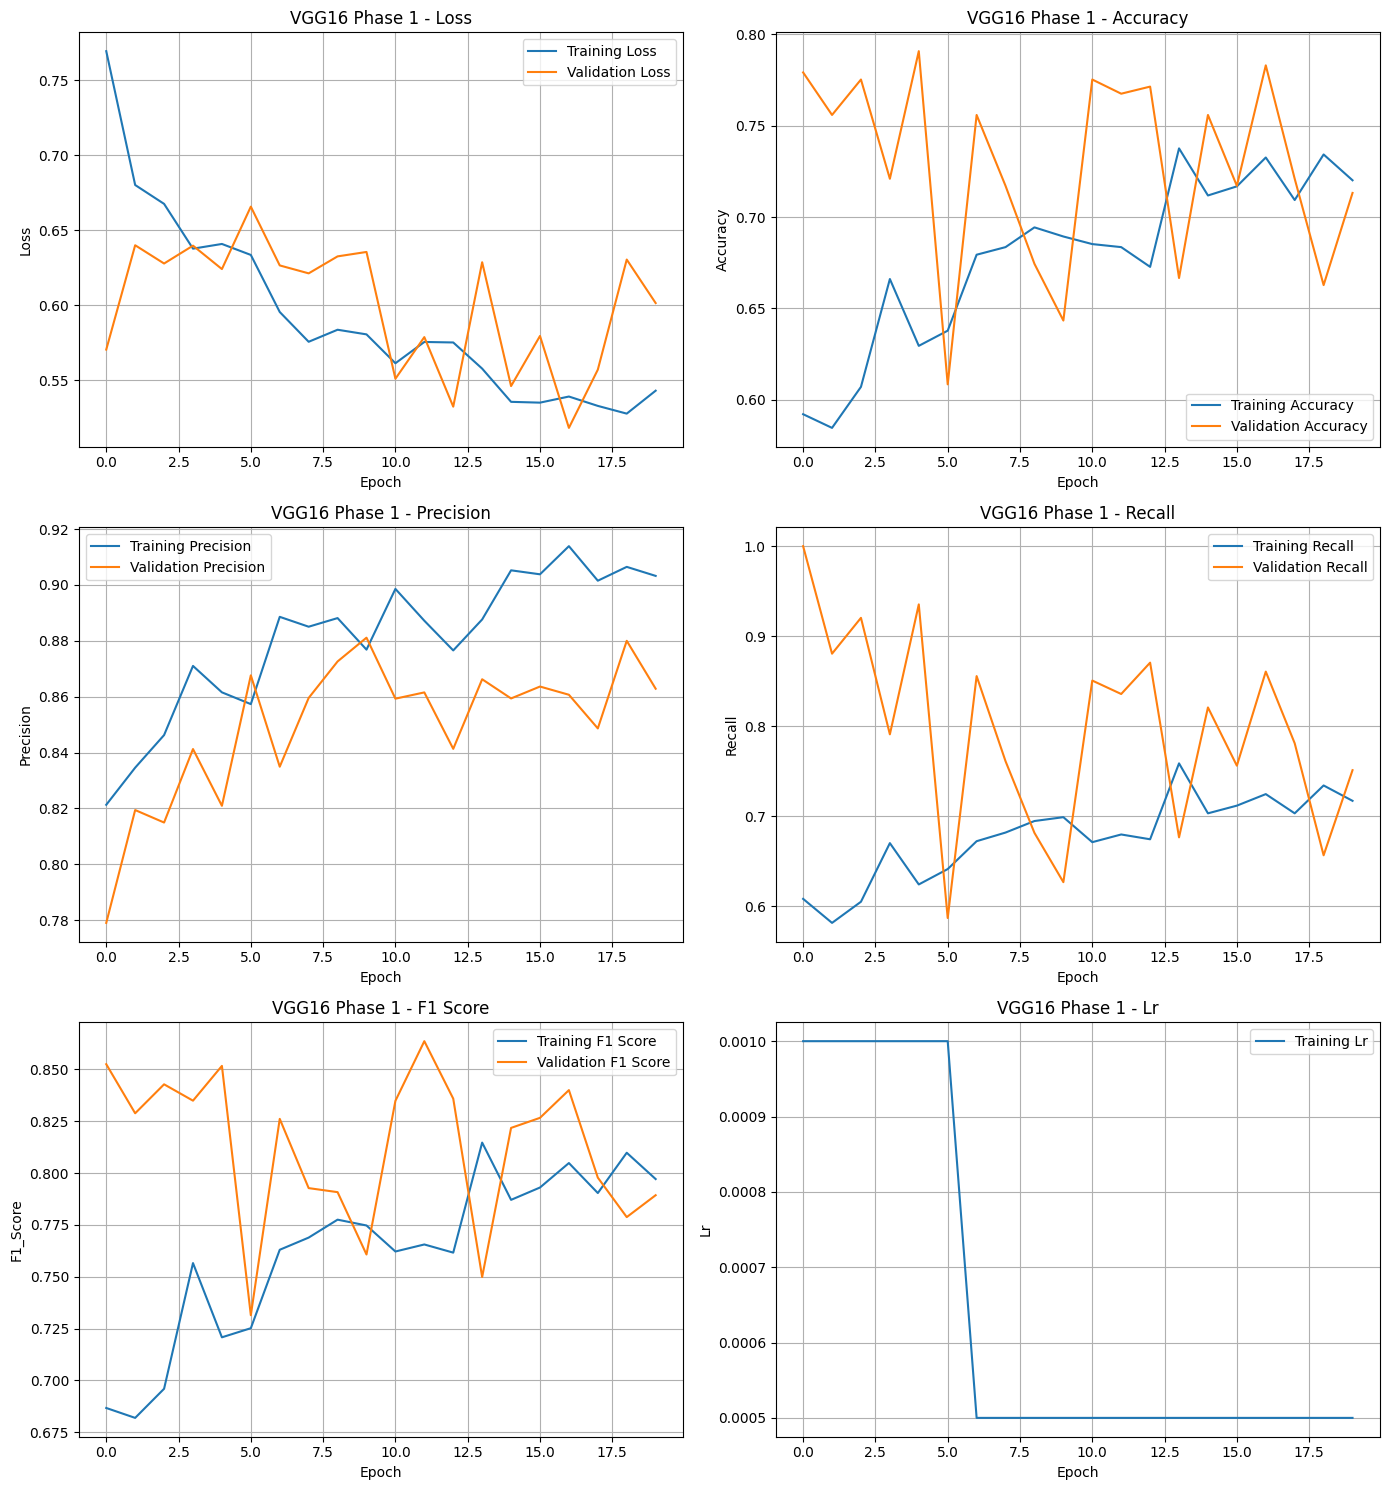

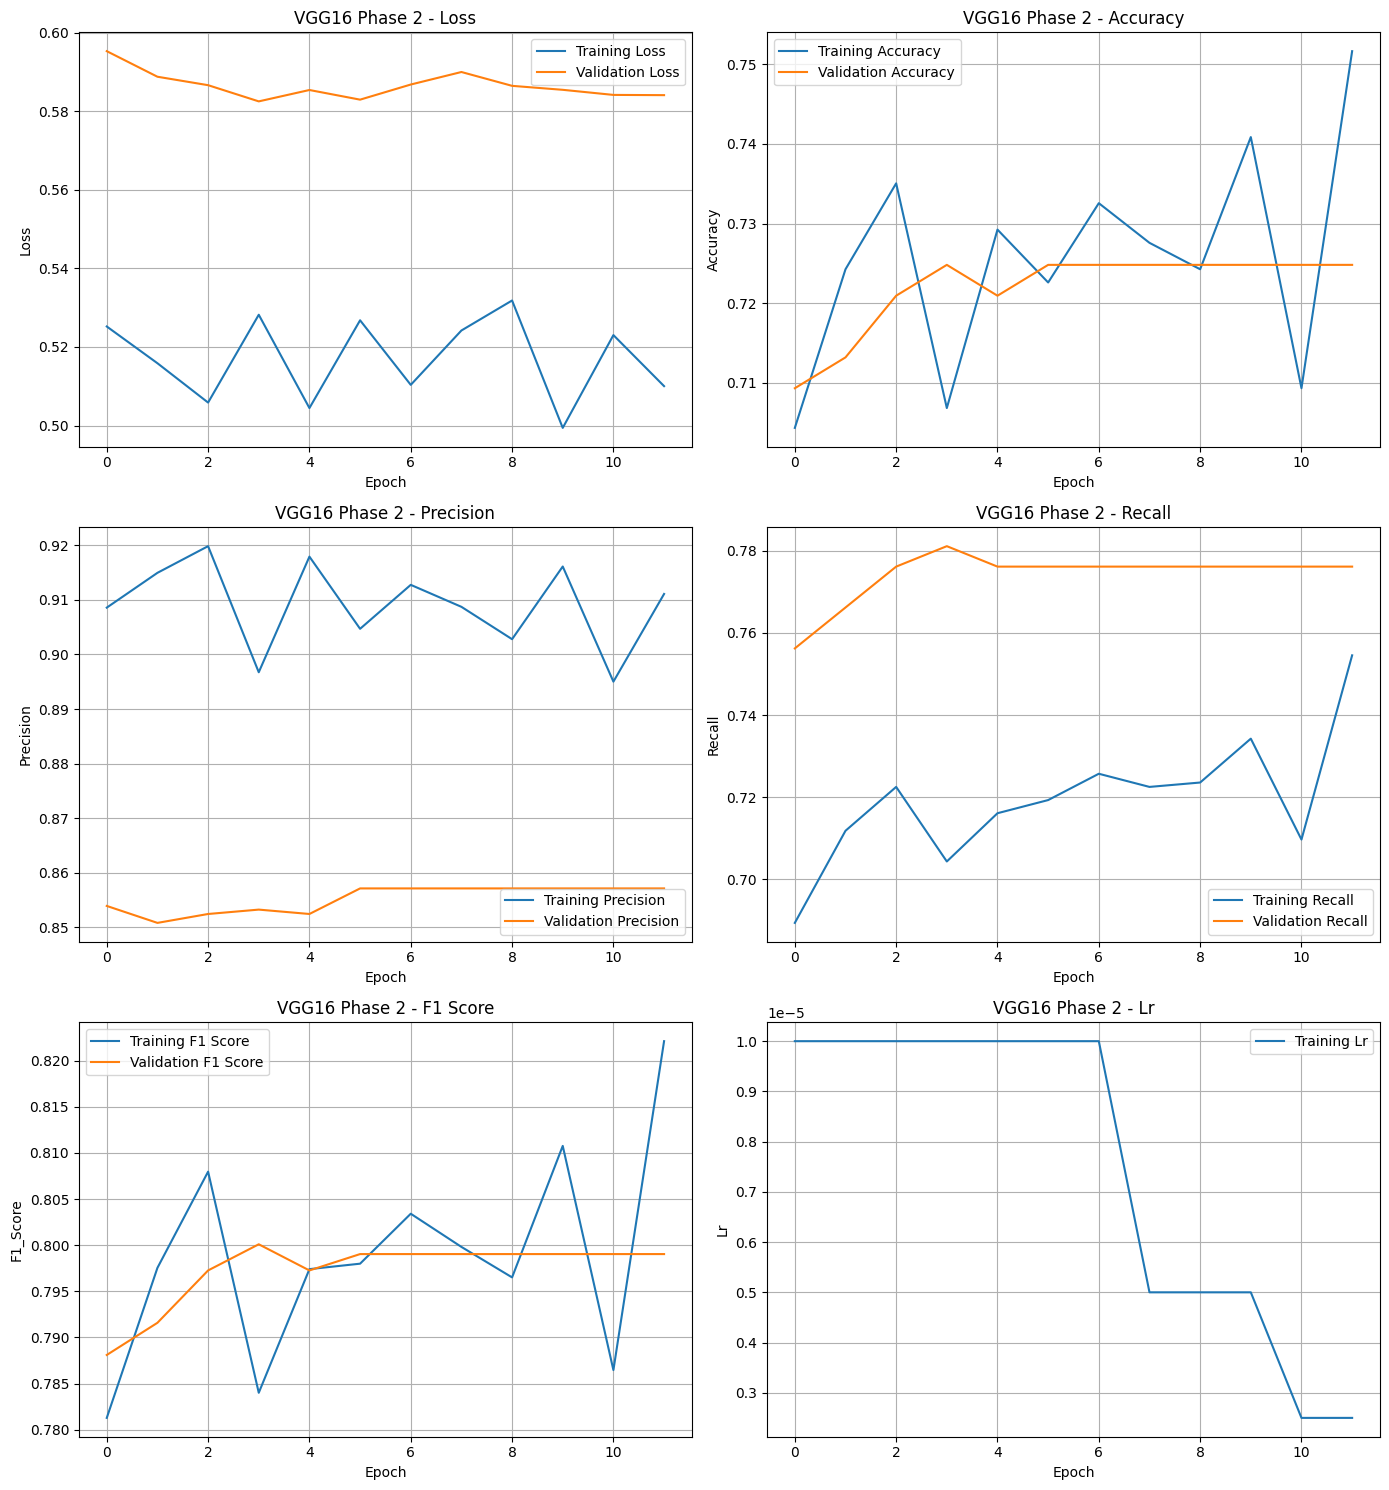


--- Training History for RESNET50 ---


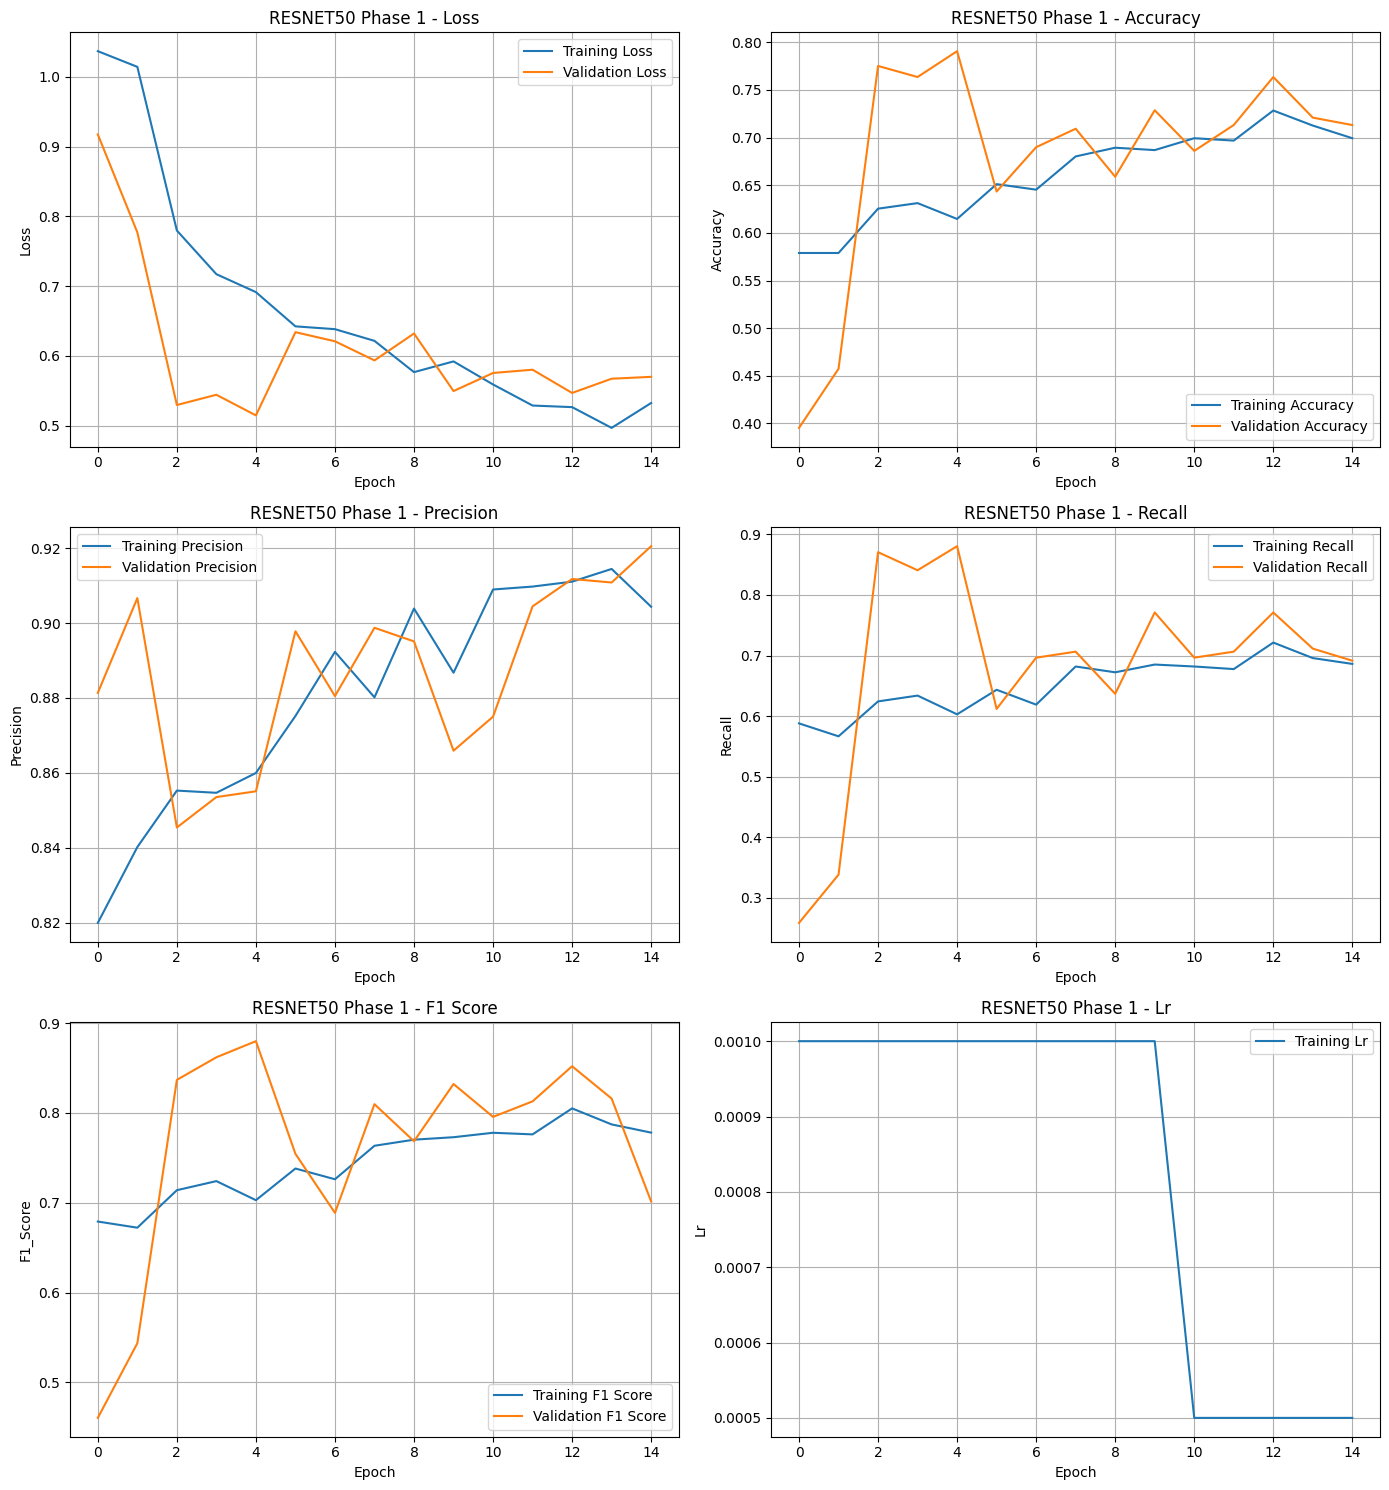

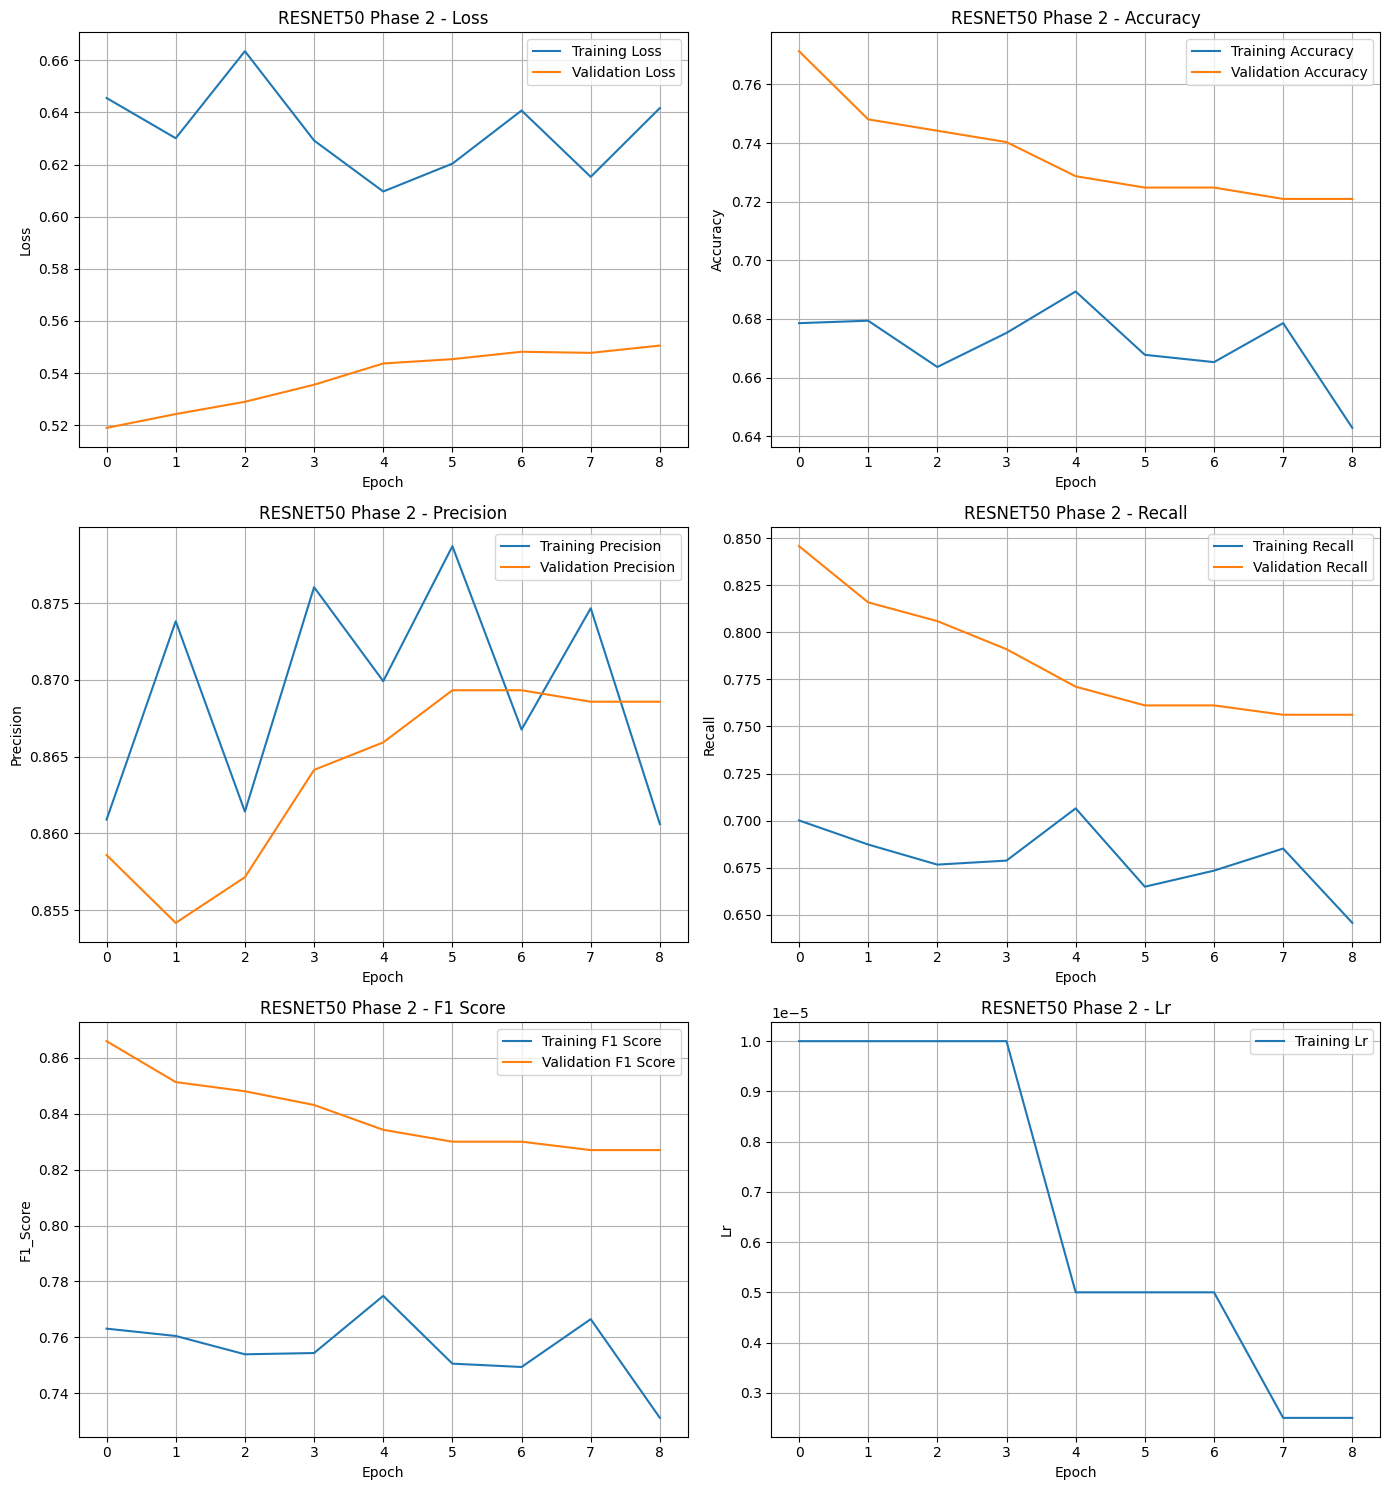


--- Training History for RESNET101 ---


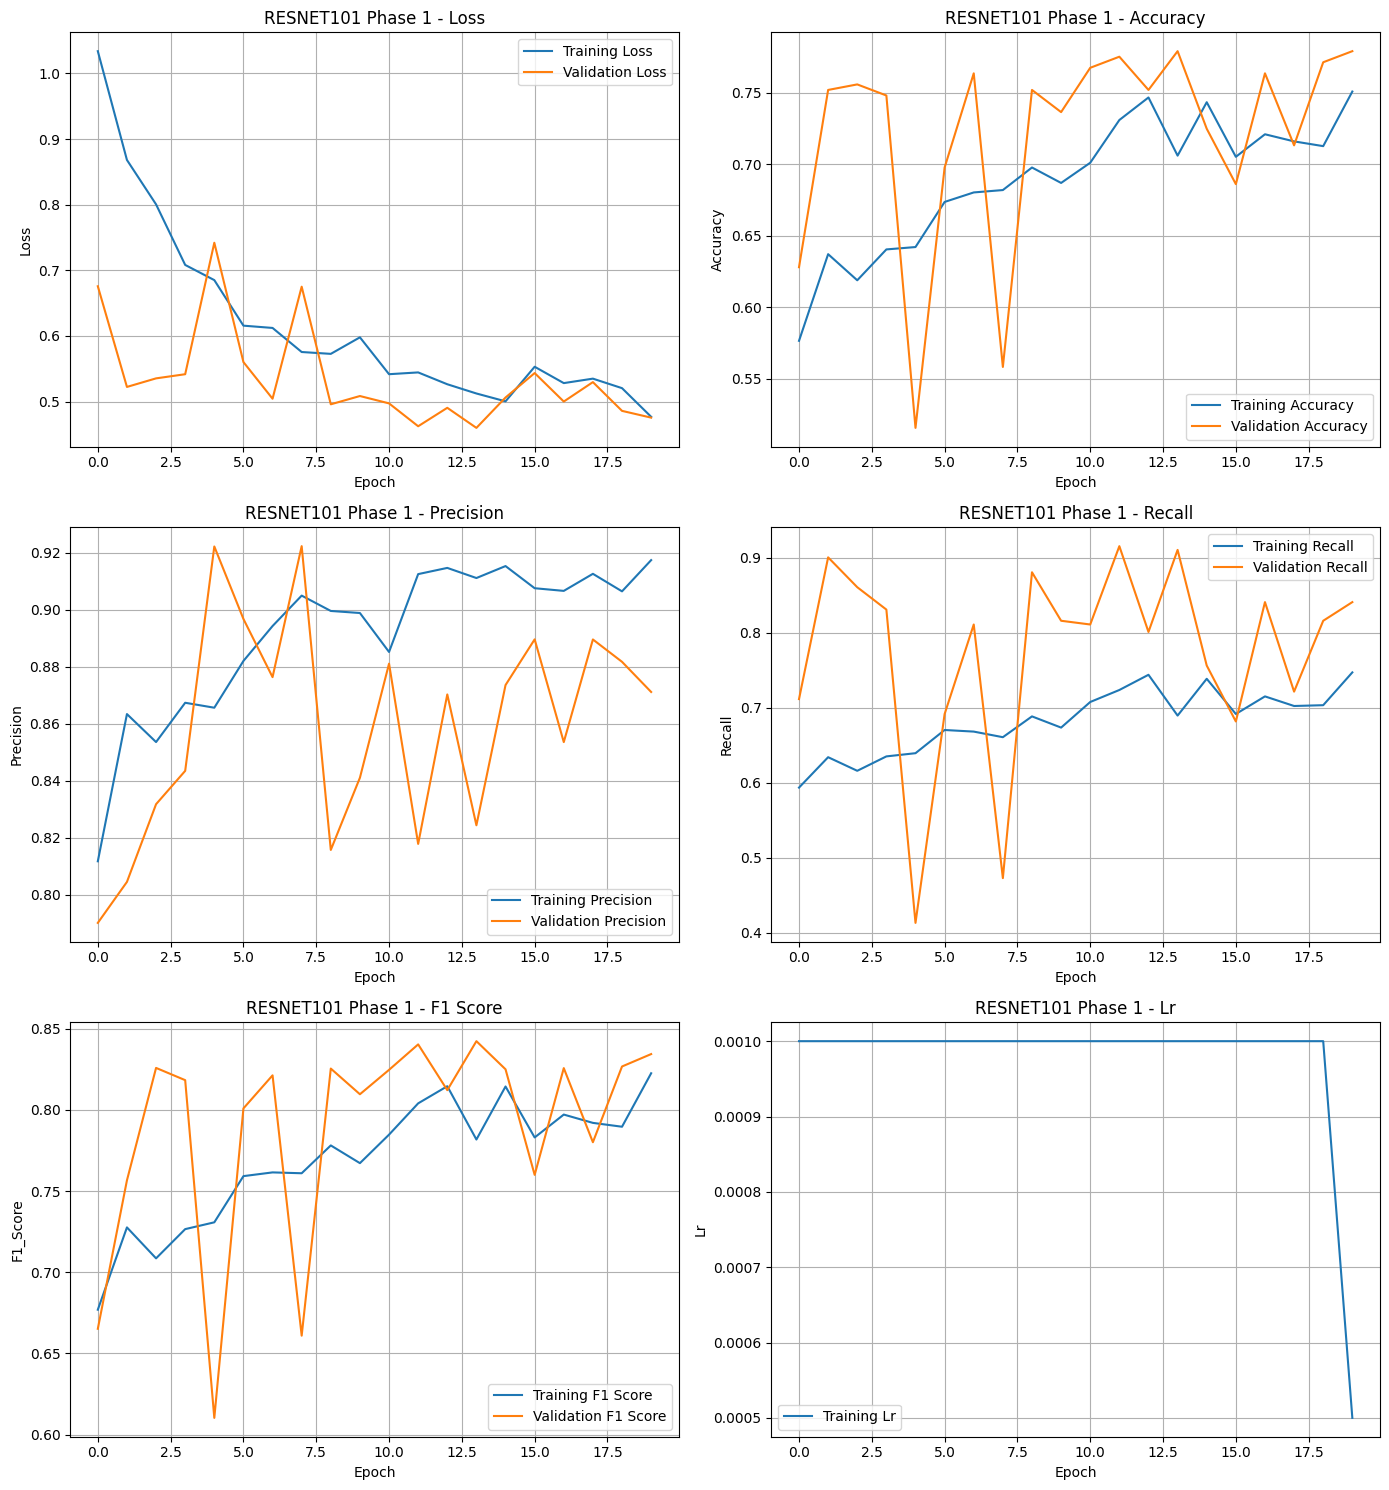

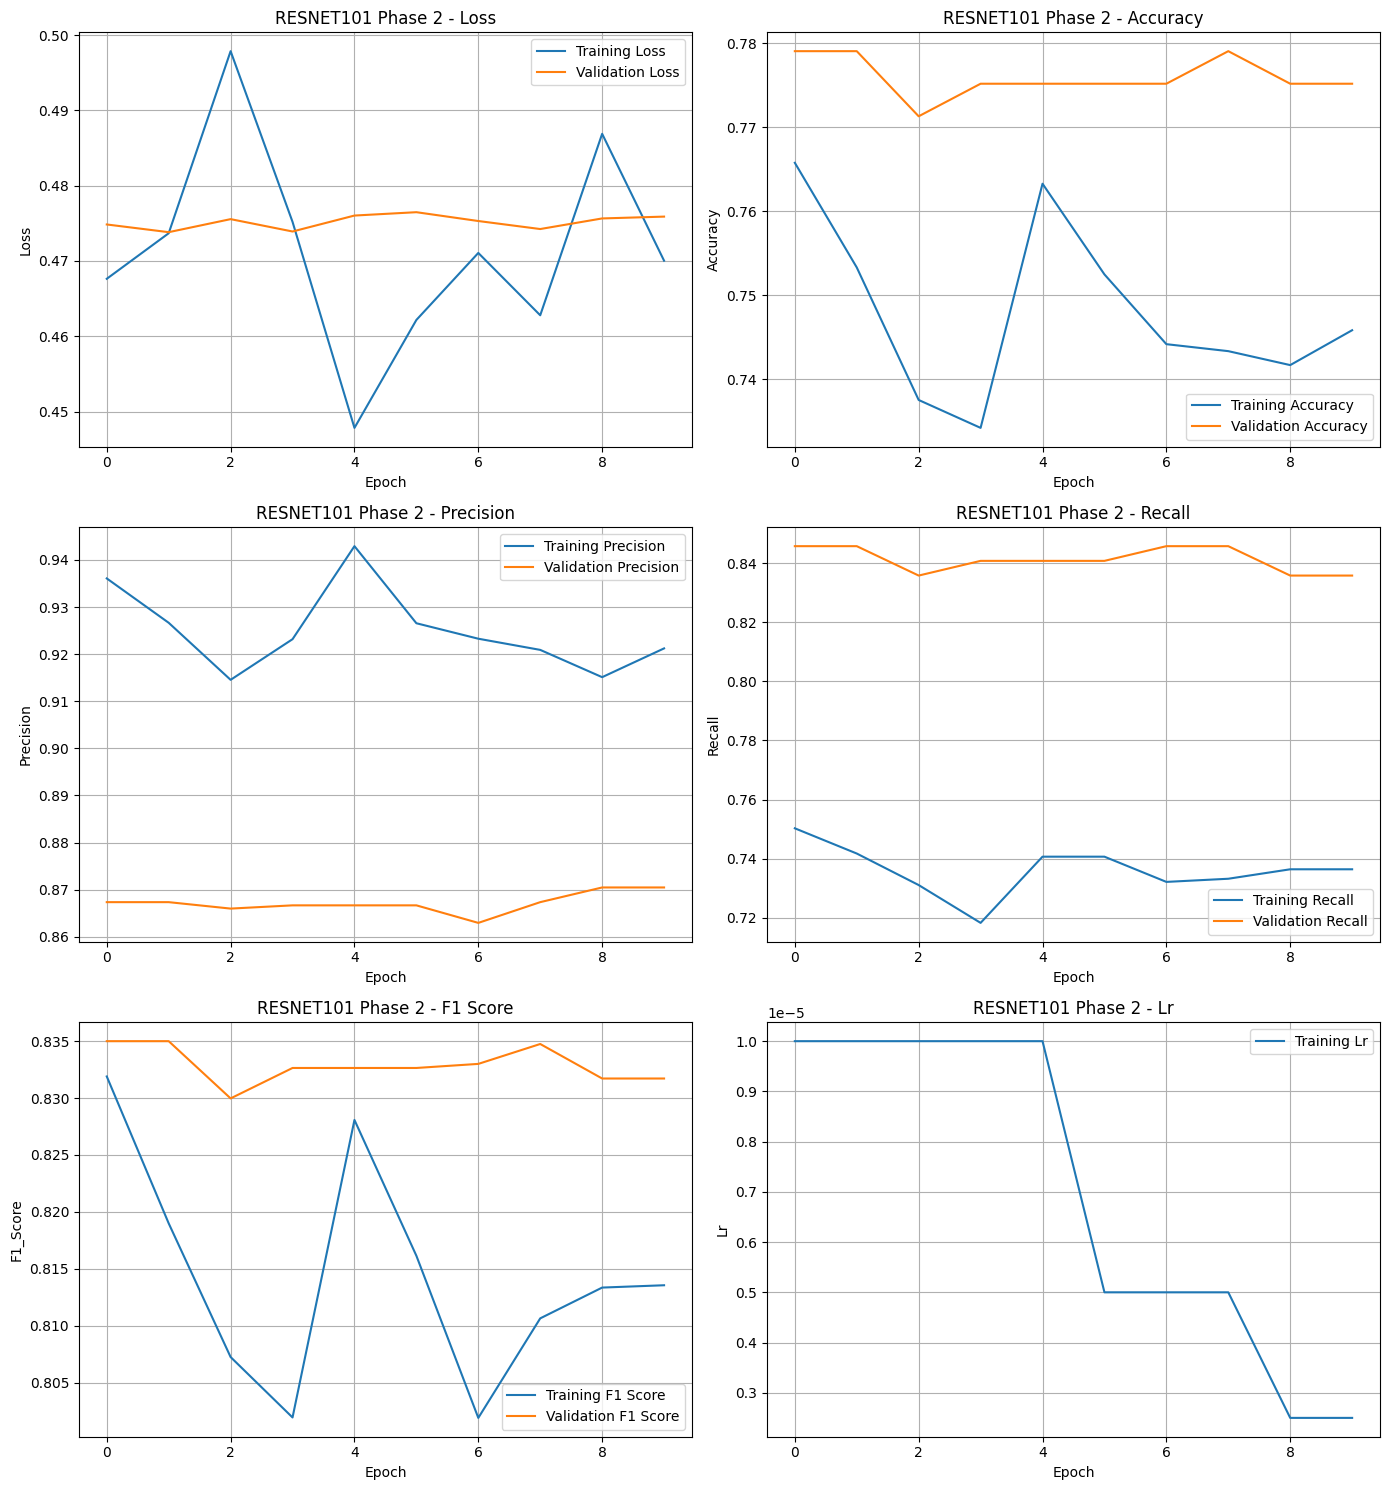


--- Training History for RESNET152 ---


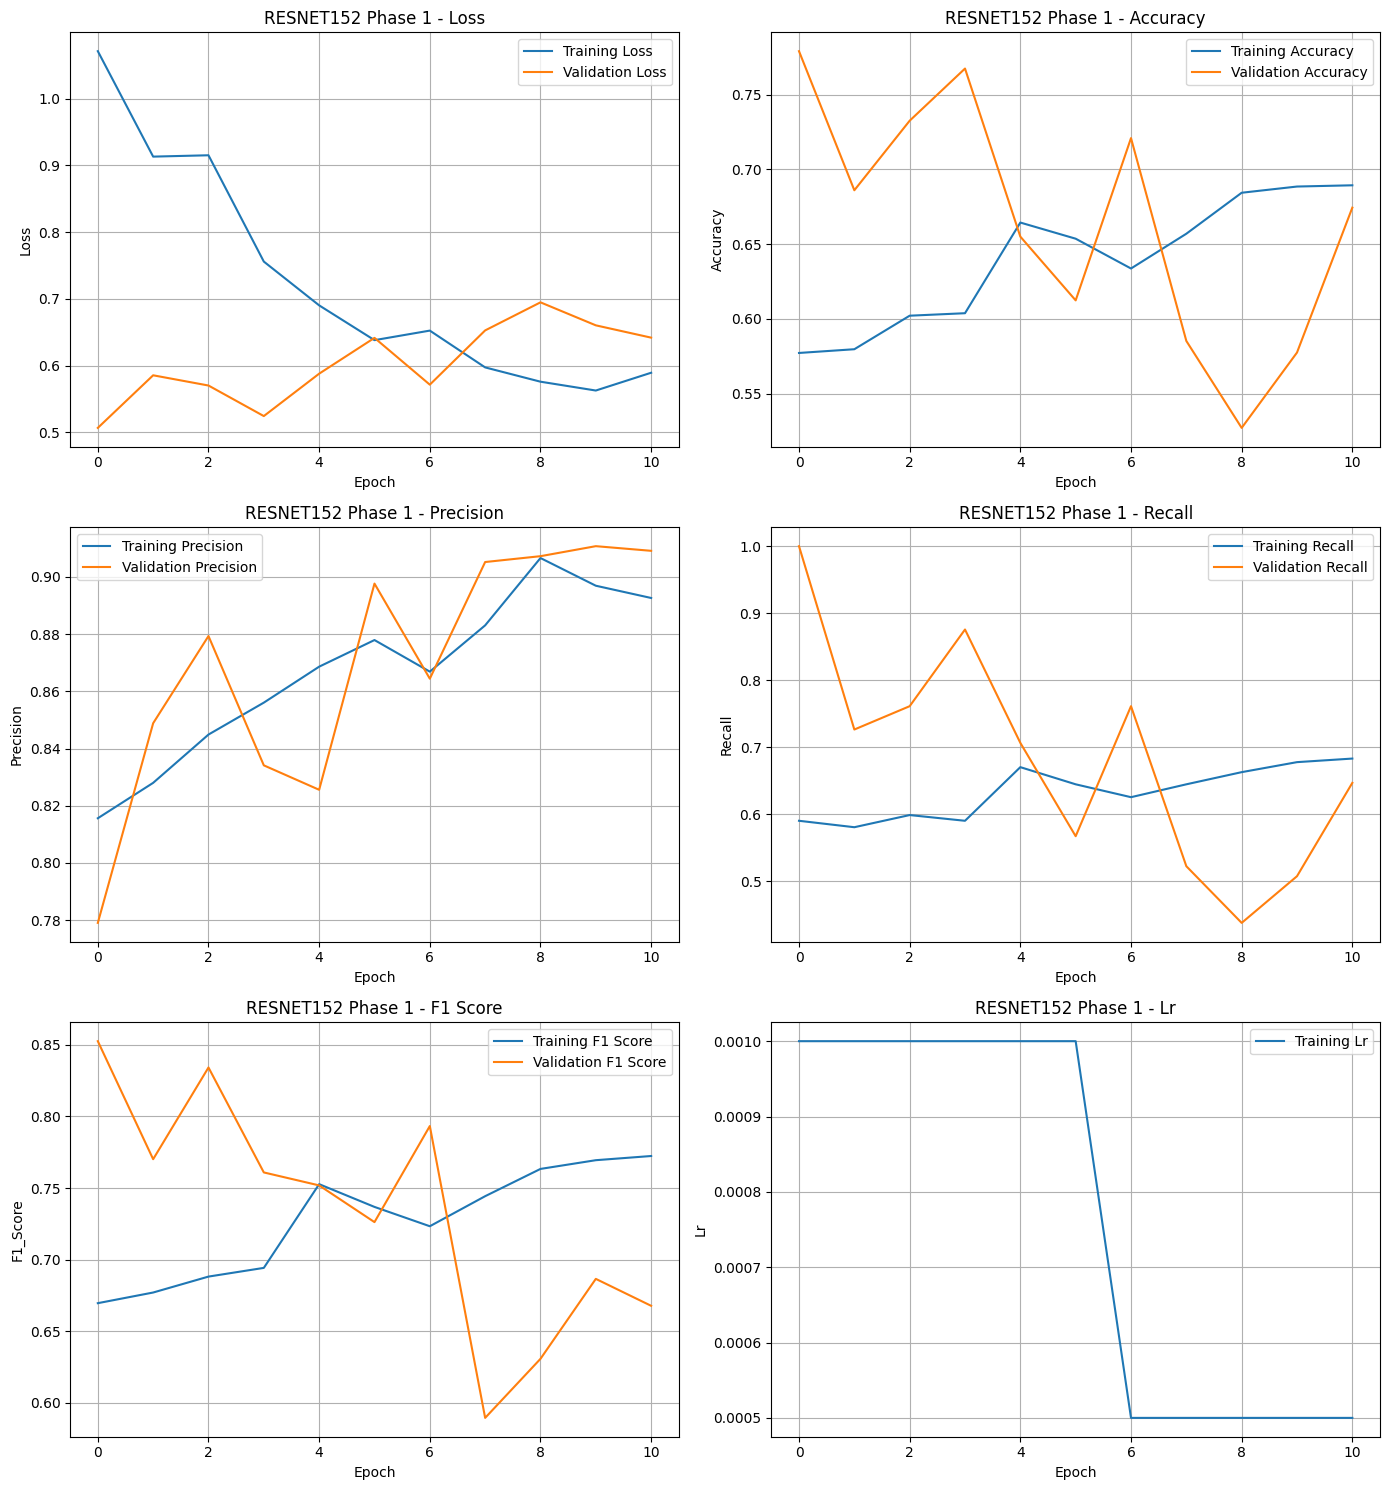

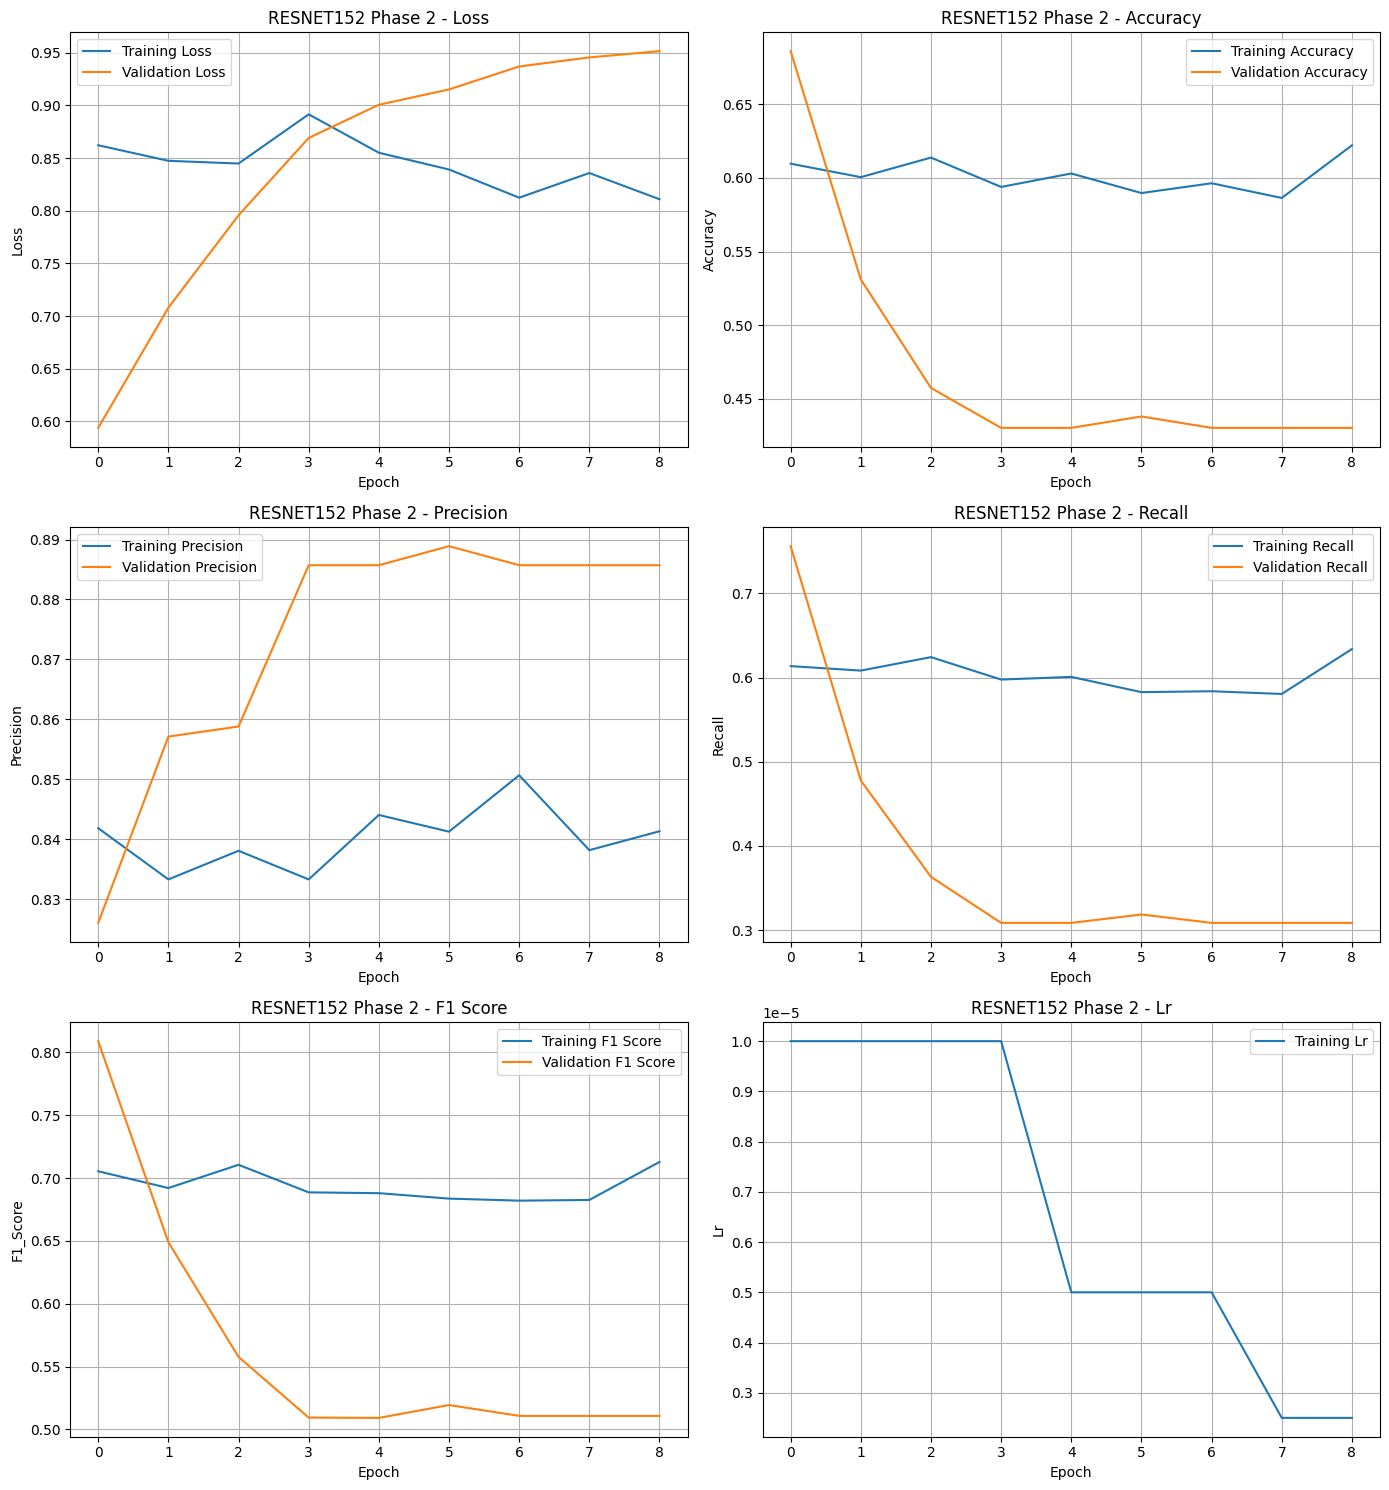

In [8]:
def plot_training_histories(history_dict, title_prefix=""):
    """
    Plots the training and validation metrics from a Keras history object.
    """
    import math
    
    # Get the metrics that were recorded
    metrics = [key for key in history_dict.keys() if not key.startswith('val_')]
    num_metrics = len(metrics)
    
    # Determine the layout of the plot
    cols = 2
    rows = math.ceil(num_metrics / cols)
    
    plt.figure(figsize=(7 * cols, 5 * rows))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(rows, cols, i)
        
        # Plot training metric
        plt.plot(history_dict[metric], label=f"Training {metric.replace('_', ' ').title()}")
        
        # Plot validation metric if it exists
        val_metric = f"val_{metric}"
        if val_metric in history_dict:
            plt.plot(history_dict[val_metric], label=f"Validation {metric.replace('_', ' ').title()}")
        
        plt.title(f"{title_prefix} - {metric.replace('_', ' ').title()}")
        plt.xlabel("Epoch")
        plt.ylabel(metric.title())
        plt.legend()
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

# Loop through all results and plot the histories for both phases
for arch, results in all_results.items():
    print(f"\n--- Training History for {arch.upper()} ---")
    plot_training_histories(results['history_phase1'], title_prefix=f"{arch.upper()} Phase 1")
    plot_training_histories(results['history_phase2'], title_prefix=f"{arch.upper()} Phase 2")

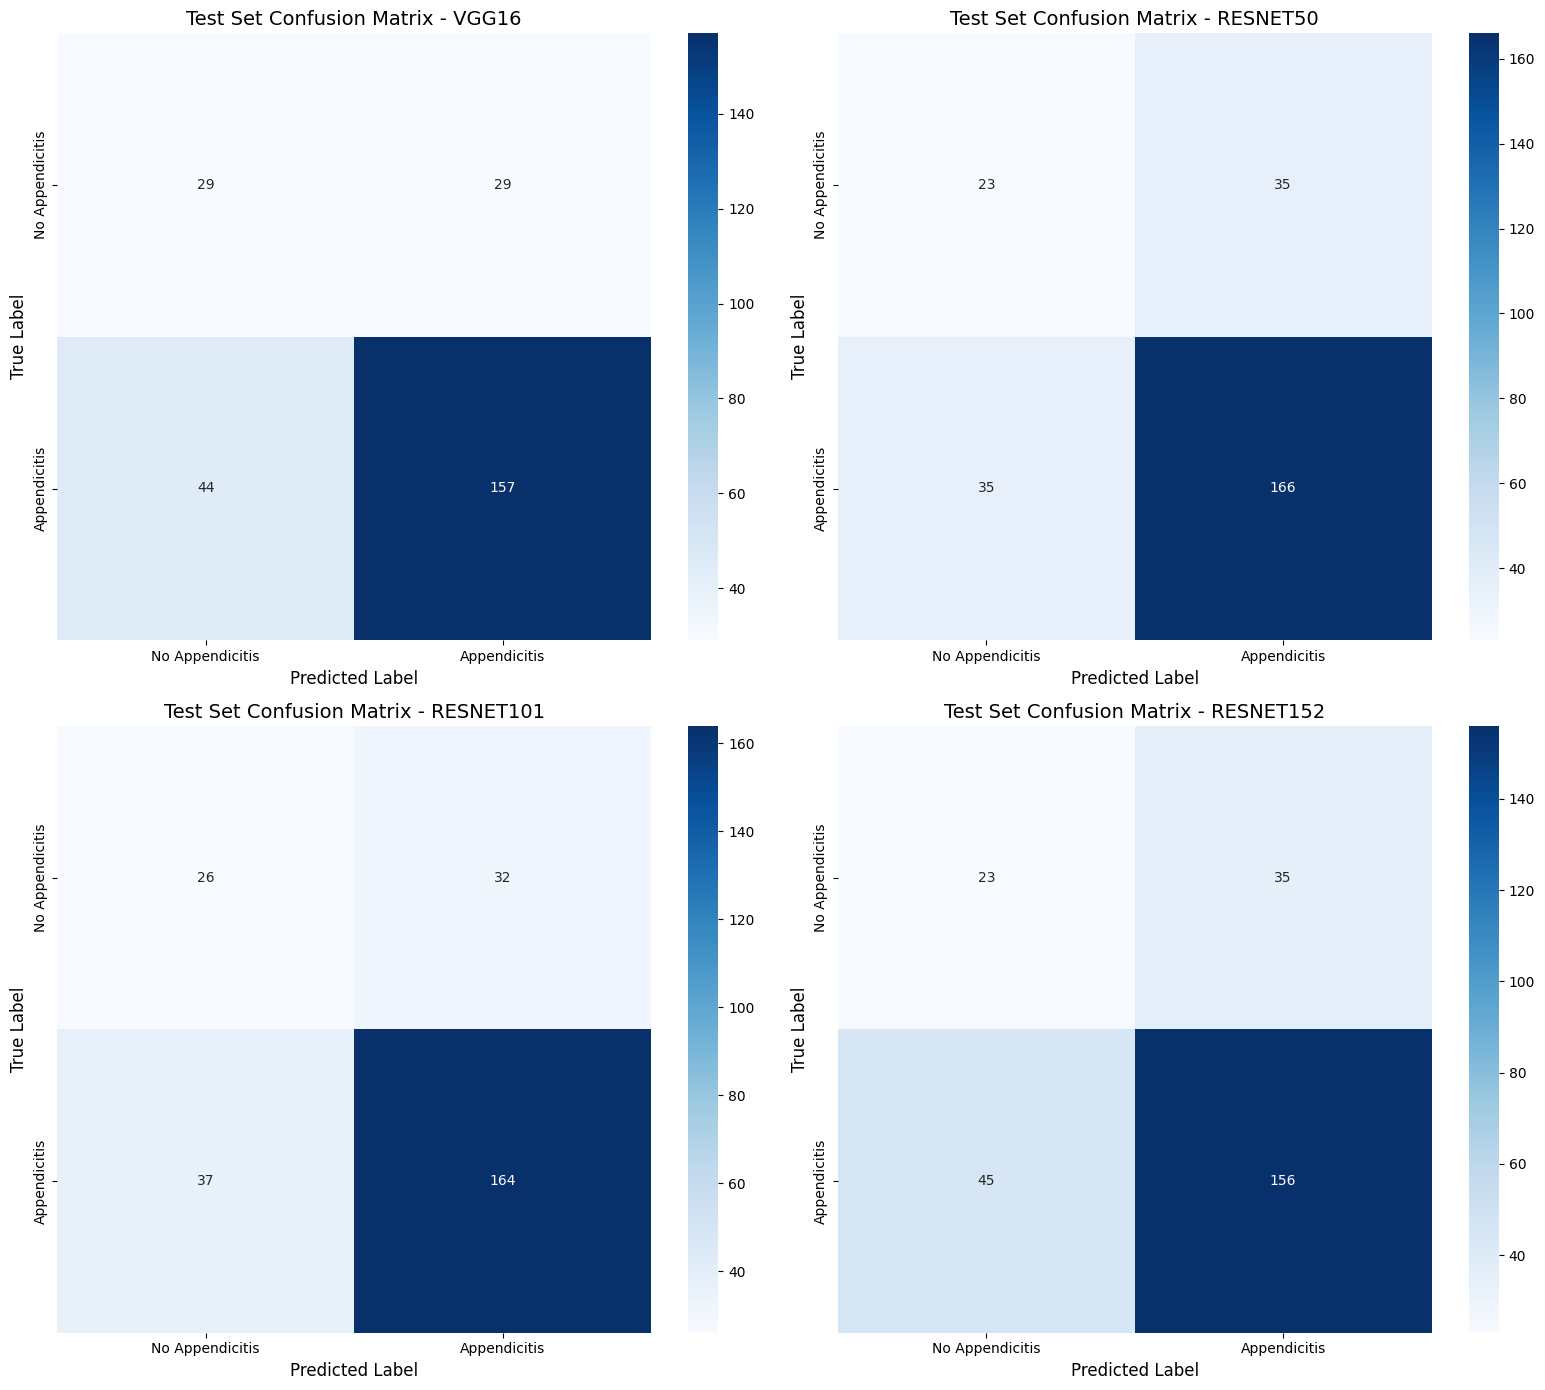

In [9]:
# --- Plotting Confusion Matrices for the Test Set ---

# Set the number of columns for our plot grid
num_models = len(all_results)
cols = 2
rows = (num_models + 1) // cols  # Calculate required rows

fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 7 * rows))
axes = axes.flatten() # Flatten the axes array for easy iteration

# Define the labels for the matrix axes
matrix_labels = ['No Appendicitis', 'Appendicitis']

# Loop through the results and plot the confusion matrix for each model
for i, (arch, results) in enumerate(all_results.items()):
    ax = axes[i]
    cm = results['test_evaluation']['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=matrix_labels,
                yticklabels=matrix_labels,
                ax=ax)
    
    ax.set_title(f'Test Set Confusion Matrix - {arch.upper()}', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)

# Hide any unused subplots if the number of models is odd
for i in range(num_models, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [11]:
# Create a list to hold the detailed summary data for each model
summary_data = []

# Loop through the results to calculate and extract final test performance
for arch, results in all_results.items():
    cm = results['test_evaluation']['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()

    # Calculate metrics from the confusion matrix components
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon()) # This is the same as sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    # Specificity was already calculated and stored, but we can recalculate for consistency
    specificity = tn / (tn + fp + K.epsilon())

    summary_data.append({
        "Architecture": arch.upper(),
        "Accuracy": f"{accuracy:.3f}",
        "F1-Score (Appendicitis)": f"{f1_score:.3f}",
        "Sensitivity (Recall)": f"{recall:.3f}",
        "Specificity": f"{specificity:.3f}",
    })

# Create a pandas DataFrame from the summary data
summary_df = pd.DataFrame(summary_data)

# Display the final, more detailed summary table
print("--- Final Model Performance on Test Set ---")
print(summary_df.to_string(index=False))

--- Final Model Performance on Test Set ---
Architecture Accuracy F1-Score (Appendicitis) Sensitivity (Recall) Specificity
       VGG16    0.718                   0.811                0.781       0.500
    RESNET50    0.730                   0.826                0.826       0.397
   RESNET101    0.734                   0.826                0.816       0.448
   RESNET152    0.691                   0.796                0.776       0.397
